In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose
from keras.constraints import max_norm
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
# Model configuration
img_width, img_height = 32, 32
batch_size = 32
no_epochs = 50
validation_split = 0.04
verbosity = 1
max_norm_value = 2.0
noise_factor = 0.25
number_of_visualizations = 10

In [5]:

x_train = x_train.reshape(x_train.shape[0],  img_width, img_height,3)
x_test = x_test.reshape(x_test.shape[0], img_width, img_height,3)


  

In [6]:
# x_shape = (3 ,img_width, img_height)

In [7]:
# Parse numbers as floats
input_train = x_train.astype('float32')
input_test = x_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255


In [8]:
# Add noise
pure = input_train
pure_test = input_test
noise = np.random.normal(0, 1, pure.shape)
noise_test = np.random.normal(0, 1, pure_test.shape)
noisy_input = pure + noise_factor * noise
noisy_input_test = pure_test + noise_factor * noise_test

In [9]:
from keras.models import load_model
from keras.models import *

In [10]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(256, kernel_size=(3, 3),padding='same')(input_img)
x = Activation('relu')(x)

for i in range(15):
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

x = Conv2D(3, (3, 3), padding='same')(x)
output_img = Activation('tanh')(x)

In [11]:
model = Model(input_img, output_img)
# model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       7168      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        147520    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        3692

In [13]:
# Compile and fit data
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(noisy_input, pure,
                epochs=no_epochs,
                batch_size=batch_size,
                validation_split=validation_split,
          callbacks=[es])

Train on 48000 samples, validate on 2000 samples
Epoch 1/50
48000/48000 [==============================] - 77s 2ms/step - loss: 0.0088 - val_loss: 0.0063
Epoch 2/50
48000/48000 [==============================] - 68s 1ms/step - loss: 0.0060 - val_loss: 0.0101
Epoch 3/50
48000/48000 [==============================] - 68s 1ms/step - loss: 0.0057 - val_loss: 0.0073
Epoch 4/50
48000/48000 [==============================] - 68s 1ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 5/50
48000/48000 [==============================] - 68s 1ms/step - loss: 0.0053 - val_loss: 0.0069
Epoch 6/50
48000/48000 [==============================] - 68s 1ms/step - loss: 0.0050 - val_loss: 0.0061
Epoch 7/50
48000/48000 [==============================] - 68s 1ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 8/50
48000/48000 [==============================] - 68s 1ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 9/50
48000/48000 [==============================] - 68s 1ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 

In [19]:
score = model.evaluate(pure_test, noisy_input_test, verbose=1)
print(score)


10000/10000 [==============================] - 4s 436us/step
0.0657684336423874


In [20]:
# Generate denoised images
samples = noisy_input_test[:15]
targets = y_test[:15]
denoised_images = model.predict(samples)

In [21]:
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

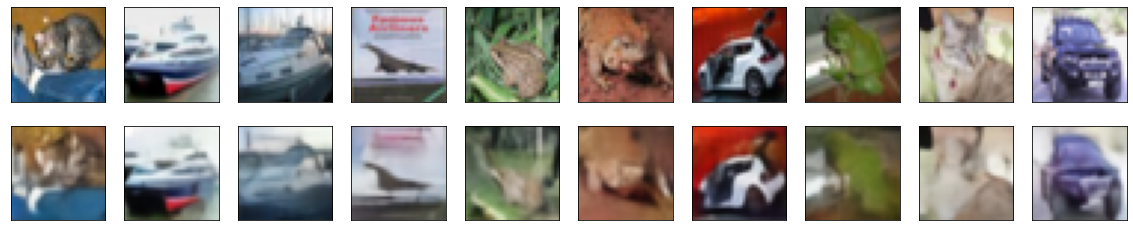

In [22]:
showOrigDec(input_test, denoised_images)

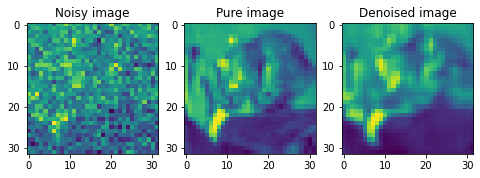

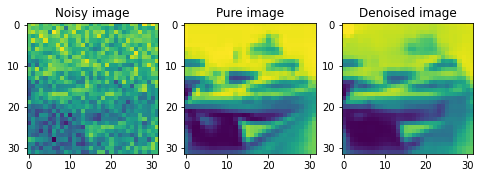

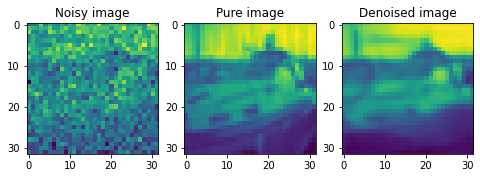

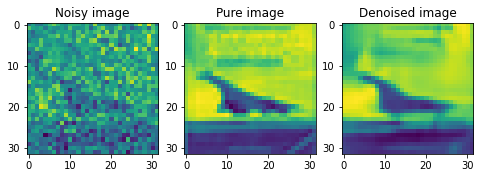

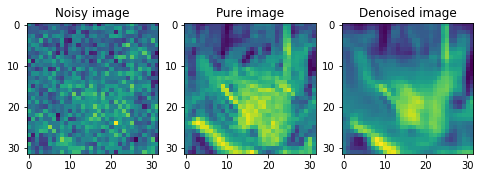

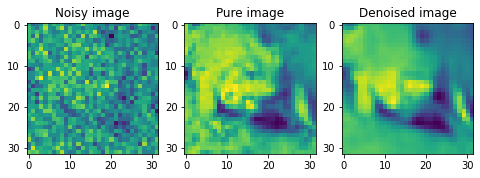

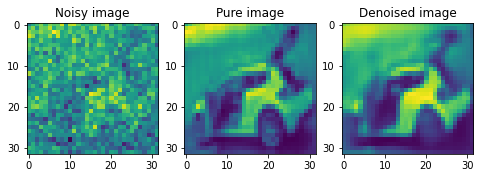

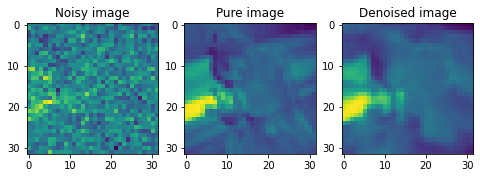

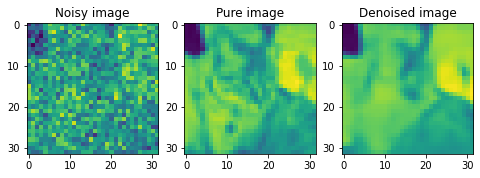

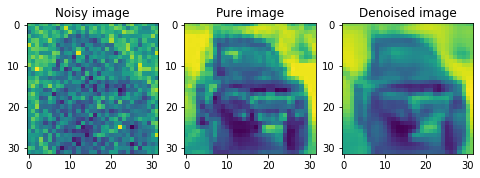

In [23]:
# Plot denoised images
for i in range(0, number_of_visualizations):
  # Get the sample and the reconstruction
  noisy_image = noisy_input_test[i][:, :, 0]
  pure_image  = pure_test[i][:, :, 0]
  denoised_image = denoised_images[i][:, :, 0]
  input_class = targets[i]
  # Matplotlib preparations
  fig, axes = plt.subplots(1, 3)
  fig.set_size_inches(8, 3.5)
  # Plot sample and reconstruciton
  axes[0].imshow(noisy_image)
  axes[0].set_title('Noisy image')
  axes[1].imshow(pure_image)
  axes[1].set_title('Pure image')
  axes[2].imshow(denoised_image)
  axes[2].set_title('Denoised image')
  
  plt.show()